# Andrej Karpathy's /makemore

#### Reference
https://www.youtube.com/watch?v=TCH_1BHY58I

https://github.com/karpathy/makemore

With Bigram char level model, we only used two chars which created a 27x27 data space. if we move deeper in this approach to enhance the loss function and the model itself, the only avenue was to explor adding more dimensions, i.e. 27x27x27. however this path suddenly explodes in terms of data and parameters that we want to use for this model.

Therefore, we need to explore a better model.

## Multi Layer Perceptron (MLP)
#### Bengio et al. 2003

This is another char level model to predict the next char, however the paper is based on word predictions. 

The proposed approach is to take 'w' number of words, and associate to each word, 'm' number of feature vectors. Meaning that, each word is embedded in a 'm' dimensional feature space. Initially these words are initialized randomly but later we'll tune them using backpropagation. 

To imagine this approach, think about words that are similar or synonyms. They will end up in the same part of the space. And those that are different will be separated. 

The modeling approach is similar to the NN approach for Bigram. They use multi-layer NN to predict the next words, given the previous words. To train the NN, they ```maximize the log-likelihood of the training data```.

Let's look at an ```example``` for this approach. Assume, we are not given the sentence "A dog was running in a room". But now for testing the model we are providing it with "A dog was running in a ..." and expecting the model to fill in the blank. Since it hasn't seen this exact sentence, we call it, ```out of distribution```. However, MLP doesn't need to have seen the exact words to predict 'room' for the blank. Because it might have seen "The dog was running in a room" and based on the learnings, it has put the embeddings of 'The' and 'A' near by each other in the space. So now that we are asking it to fill the blank based on "A dog was running in a ...", it will match it up with "The dog was running in a room". This is called ```knowledge transfer```.

Let's look at the ```architecture``` of this approach. 

Assume the NN's input, takes 3 previous-words. And the output is the fourth word. Each of the incoming words, will go through a look-up table, to match up the corresponding embedding ('m' feature vector) for that word. So there will be $3 \times m$ neurons holding the 3 words. 

Then we need to build a hidden layer. The size is a ```hyper-parameter```. Meaning that, we need to come up with the right size based on try-error. So all the input neurons goes into the hidden layer. And there will be a ```tanh``` function applied for non-linearity. 

The output layer is a huge one, because the number of neurons is equivalent to $w$, the number of words in our data set. All the neurons in the hidden layer are connected to the output neurons. That's why there will be lots of params in between these two layers, and therefore, it's going to be computationally expensive. On top of the output layer we have ```softmax``` (exponentiate the logits and normalize, so that it will sum up to 1). This way, we'll get a nice probability distribution for the next word in the sequence. 

During training, because we have xs and ys, we will get the probability for each x and minimize the NN's loss by improving the parameters. The optimization used here is also ```backpropagation```.

In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
import os

# read from another package while we are in a separate package
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = os.path.join(parent_directory, 'opensource/makemore', 'names.txt')

words = open(file_path, 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [62]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### build the dataset

In [63]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words[:5]: # the examples we can generate from the first 5 words
    print(w)
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '--->', i2s[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [64]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [65]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### Build The Embeddings

the paper used 70000 words with 30 embeddings. we have 27 chars, so we'll go with 2 embeddings.

In [66]:
C = torch.randn((27, 2))
C[5]

tensor([-1.3004, -0.6561])

In [67]:
# retrieve embeddings with a list of lookups
C[[5,6,8]]

tensor([[-1.3004, -0.6561],
        [-0.3903,  0.2140],
        [ 0.6566, -0.8840]])

In [68]:
# therefore this works
emb = C[X]
emb

tensor([[[-0.5074, -1.8076],
         [-0.5074, -1.8076],
         [-0.5074, -1.8076]],

        [[-0.5074, -1.8076],
         [-0.5074, -1.8076],
         [-1.3004, -0.6561]],

        [[-0.5074, -1.8076],
         [-1.3004, -0.6561],
         [ 1.0227,  0.9855]],

        [[-1.3004, -0.6561],
         [ 1.0227,  0.9855],
         [ 1.0227,  0.9855]],

        [[ 1.0227,  0.9855],
         [ 1.0227,  0.9855],
         [ 0.6858, -1.1174]],

        [[-0.5074, -1.8076],
         [-0.5074, -1.8076],
         [-0.5074, -1.8076]],

        [[-0.5074, -1.8076],
         [-0.5074, -1.8076],
         [ 0.0346,  0.3226]],

        [[-0.5074, -1.8076],
         [ 0.0346,  0.3226],
         [-2.1583, -0.1153]],

        [[ 0.0346,  0.3226],
         [-2.1583, -0.1153],
         [ 0.2075,  0.1068]],

        [[-2.1583, -0.1153],
         [ 0.2075,  0.1068],
         [ 1.1989,  0.2576]],

        [[ 0.2075,  0.1068],
         [ 1.1989,  0.2576],
         [ 0.2075,  0.1068]],

        [[ 1.1989,  0

#### hidden layer

In [69]:
hidden_layer_hyperparameter_size = 100
num_of_words = 3
num_of_embeddings = 2
num_of_inputs = num_of_words * num_of_embeddings

w1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size))
b1 = torch.randn((hidden_layer_hyperparameter_size))



In [70]:
X.shape

torch.Size([32, 3])

In [71]:
C.shape

torch.Size([27, 2])

In [72]:
emb.shape

torch.Size([32, 3, 2])

In [73]:
w1.shape

torch.Size([6, 100])

wee want to setup the tensor's shapes in such a way that ```emb @ w1 + b1``` would work.

http://blog.ezyang.com/2019/05/pytorch-internals/


In [74]:
x_size = emb.shape[0] # or use -1 for pytorch to figure it out
emb.view(x_size, num_of_inputs) @ w1 + b1

tensor([[-2.6134, -3.1258,  0.7510,  ..., -0.8199, -9.1942, -2.6622],
        [-2.8158, -0.8962,  0.6558,  ..., -0.4174, -7.9463, -2.2584],
        [-2.4356, -1.1802,  1.7480,  ..., -0.9424,  0.1159, -5.3092],
        ...,
        [-0.3765, -1.2361,  1.2702,  ...,  0.4268, -1.0929, -5.3421],
        [ 0.9624,  2.8507, -0.3402,  ..., -1.6579, -3.0843, -2.4998],
        [-0.3146, -2.7932,  0.6544,  ..., -0.6907, -0.2089,  0.6663]])

In [75]:
# hidden layer
h = torch.tanh(emb.view(-1, num_of_inputs) @ w1 + b1) # added tanh to bring all the values between -1 and 1 for non-linearity
h 

tensor([[-0.9893, -0.9962,  0.6357,  ..., -0.6750, -1.0000, -0.9903],
        [-0.9929, -0.7144,  0.5756,  ..., -0.3948, -1.0000, -0.9784],
        [-0.9848, -0.8275,  0.9411,  ..., -0.7363,  0.1154, -1.0000],
        ...,
        [-0.3596, -0.8443,  0.8539,  ...,  0.4027, -0.7979, -1.0000],
        [ 0.7453,  0.9933, -0.3277,  ..., -0.9299, -0.9958, -0.9866],
        [-0.3046, -0.9925,  0.5747,  ..., -0.5984, -0.2060,  0.5826]])

#### output layer

In [76]:
# output layer
w2 = torch.randn((hidden_layer_hyperparameter_size, 27))
b2 = torch.randn((27))
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

In [77]:
counts = logits.exp() # get fake counts
probs = counts / counts.sum(1, keepdim=True) # normalize to get the probabilities
probs.shape


torch.Size([32, 27])

In [78]:
# proof of normalized probs is to check if every row sums up to =1
probs[0].sum()

tensor(1.0000)

In [79]:
probs[torch.arange(32), Y]

tensor([3.8062e-15, 2.4791e-06, 2.2159e-06, 4.8267e-13, 3.8968e-05, 2.4880e-10,
        2.4705e-11, 3.0781e-11, 1.1198e-05, 2.6618e-02, 1.0043e-10, 5.2040e-05,
        4.4300e-10, 3.5379e-02, 1.0168e-09, 1.1452e-06, 5.7345e-12, 2.7056e-01,
        3.6719e-10, 1.1366e-09, 9.9913e-03, 1.0114e-04, 8.1555e-09, 8.3999e-06,
        5.9968e-07, 4.3684e-07, 2.9054e-12, 2.2178e-07, 2.6081e-10, 5.9232e-06,
        1.5525e-10, 2.2173e-05])

#### Training on Small Dataset (over-fitting)

we haven't trained the NN yet so the probabilities are far from 1.

In [80]:
# we need to minimize this loss
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(16.4829)

let's put everything together

In [82]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [83]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [84]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp() # (32, 27)
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697, grad_fn=<NegBackward0>)

instead of using the above code we can also use pytorch library to arrive at the same loss, which is more efficient. 

In [85]:
F.cross_entropy(logits, Y)

tensor(17.7697, grad_fn=<NllLossBackward0>)

let's setup the training procedure

In [87]:
for _ in range(100):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  3.985849380493164
loss ->  3.6028308868408203
loss ->  3.2621421813964844
loss ->  2.961381435394287
loss ->  2.6982975006103516
loss ->  2.469712734222412
loss ->  2.271660566329956
loss ->  2.101283550262451
loss ->  1.9571772813796997
loss ->  1.8374857902526855
loss ->  1.7380967140197754
loss ->  1.653511643409729
loss ->  1.5790899991989136
loss ->  1.5117664337158203
loss ->  1.449604868888855
loss ->  1.3913118839263916
loss ->  1.3359922170639038
loss ->  1.2830528020858765
loss ->  1.2321910858154297
loss ->  1.18338143825531
loss ->  1.136798620223999
loss ->  1.092664122581482
loss ->  1.051092267036438
loss ->  1.0120269060134888
loss ->  0.9752703309059143
loss ->  0.940556526184082
loss ->  0.9076125621795654
loss ->  0.8761920928955078
loss ->  0.8460890650749207
loss ->  0.8171356916427612
loss ->  0.7891989946365356
loss ->  0.7621745467185974
loss ->  0.7359813451766968
loss ->  0.7105579972267151
loss ->  0.6858609914779663
loss ->  0.6618651747703552
loss 

so far we reached above optimized loss with 5 words and 32 examples. so let's pull in all the data.

#### Training On Full Dataset

In [89]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words: # the examples we can generate from the first 5 words
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [93]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [95]:
for _ in range(100):
    # forward pass
    emb = C[X] 
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  10.709587097167969
loss ->  10.407631874084473
loss ->  10.127808570861816
loss ->  9.864364624023438
loss ->  9.614503860473633
loss ->  9.376439094543457
loss ->  9.148944854736328
loss ->  8.931110382080078
loss ->  8.722230911254883
loss ->  8.521748542785645
loss ->  8.329227447509766
loss ->  8.144325256347656
loss ->  7.966791152954102
loss ->  7.796450614929199
loss ->  7.633185386657715
loss ->  7.476908206939697
loss ->  7.327521800994873
loss ->  7.184885501861572
loss ->  7.048791885375977
loss ->  6.918952465057373
loss ->  6.795018196105957
loss ->  6.676602840423584
loss ->  6.563319206237793
loss ->  6.454790115356445
loss ->  6.350668907165527
loss ->  6.250643253326416
loss ->  6.15443229675293
loss ->  6.06178617477417
loss ->  5.972482681274414
loss ->  5.886328220367432
loss ->  5.803147792816162
loss ->  5.722784519195557
loss ->  5.645095348358154
loss ->  5.5699462890625
loss ->  5.497213840484619
loss ->  5.426781177520752
loss ->  5.358536243438721
lo

#### Mini-Batch

The reason why above training takes a lot of time is that, it's doing a forward and backward pass on a large dataset. To optimize the training process we introduce mini-batches. 

With mini-batch, we do the forward and backward passes on a smaller dataset. Once optimized we move to another batch for training and optimizing the loss.

In [100]:
for _ in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  2.343358039855957
loss ->  2.5761938095092773
loss ->  2.2467153072357178
loss ->  2.3134658336639404
loss ->  1.9506323337554932
loss ->  2.6099228858947754
loss ->  2.0967602729797363
loss ->  2.2388033866882324
loss ->  2.25968599319458
loss ->  2.265740156173706
loss ->  2.548616886138916
loss ->  1.7506353855133057
loss ->  2.8751585483551025
loss ->  2.7745673656463623
loss ->  1.8377327919006348
loss ->  2.4854981899261475
loss ->  2.0249948501586914
loss ->  2.330305337905884
loss ->  2.407785654067993
loss ->  2.726006269454956
loss ->  2.4352259635925293
loss ->  2.1189327239990234
loss ->  2.480989933013916
loss ->  2.2646238803863525
loss ->  2.240161418914795
loss ->  2.383603811264038
loss ->  2.3747398853302
loss ->  2.2474868297576904
loss ->  2.265019178390503
loss ->  2.085399866104126
loss ->  2.5529844760894775
loss ->  2.0036675930023193
loss ->  2.5144033432006836
loss ->  2.1372337341308594
loss ->  2.318549871444702
loss ->  1.9543728828430176
loss ->  

now you can see that thee training is much faster and therefore, you can afford to increase the iterations for further minimizing the loss.

#### Learning Rate

How do you determine the learning rate? How do you know if it's too small (moving too slowly towards an optimized loss), or it's too big (over-stepping and missing the optimized loss)?

One way is to find the min and max range, first. You can provide -0.0001 or lower and find the value that demonstrates a reasonable decrease in the loss. Then find a big number with the same analogy. Based in this, we can see that, the optimized learning rate should be between -0.001 and -1.

We can use pytorch's library to create a linear array of learning rates between these two numbers for, say 1000 steps.

In [101]:
lre = torch.linspace(-3, 0, 1000) # linear rate exponential
lrs = 10**lre # learning rates: 10^-3 = 0.001 and 10^0 = 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

now let's reset everything and iterate through possible learning rates to find the best match

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

loss ->  2.1068224906921387
loss ->  2.4579553604125977
loss ->  2.2688448429107666
loss ->  1.6855255365371704
loss ->  2.457881450653076
loss ->  2.037208318710327
loss ->  2.0690746307373047
loss ->  2.3032195568084717
loss ->  2.7215311527252197
loss ->  1.904735803604126
loss ->  2.4351987838745117
loss ->  2.4516847133636475
loss ->  2.0160207748413086
loss ->  2.134155750274658
loss ->  2.0672080516815186
loss ->  2.3296079635620117
loss ->  2.107666015625
loss ->  2.2208847999572754
loss ->  2.4583420753479004
loss ->  1.92301344871521
loss ->  2.5815346240997314
loss ->  2.258862257003784
loss ->  2.206108808517456
loss ->  2.1114749908447266
loss ->  2.3371829986572266
loss ->  2.4083943367004395
loss ->  2.5233583450317383
loss ->  2.1591427326202393
loss ->  2.0235626697540283
loss ->  2.5124928951263428
loss ->  2.2697577476501465
loss ->  2.4515655040740967
loss ->  2.1295182704925537
loss ->  2.02724289894104
loss ->  2.2297043800354004
loss ->  2.3201208114624023
loss -

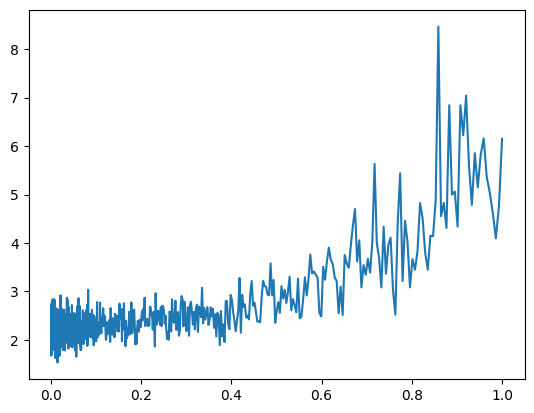

In [102]:
# track the learning rates in respect to its loss
lr_i = []
loss_i = []

for i in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data.add_(-lr * p.grad)

    lr_i.append(lr)
    loss_i.append(loss.item())

plt.plot(lr_i, loss_i)

as you can see the learning rate was stable between 0.0 and 0.1, and after that it became unstable. So we have narrowed down the learning rate's range in respect to minimized loss function. So we can choose 0.1 safely now and also increase the iteration.

In [104]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [109]:
for i in range(10000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    # print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

In [110]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('loss -> ', loss.item())

loss ->  2.355053186416626


#### Learning Rate Decay

One more thing to remember is that, once we found our optimized learning rate, we can run the training with it a few times. But then you realize the loss is not moving lower by much. In that case, on a trained NN, you can further reduce the learning rate, by a factor of 10, and continue thee training with same amount of iterations. You can continue this until you reach a plateau. This approach is called learning decay.

#### Data Split - Train/Validate/Test

If you increase your parameters to exceed your input size, you will end up over-fitting the data. Meaning that, your NN will memorize the data and outputs exactly what it saw, rather then being creative and output something new. 

To make sure we are not over-fitting or under-fitting we can split the data into training (80%), validation/dev (10%), and testing sets (10%). 

Validation is used to find the best hyper-params and settings of the NN. You can try multiple variations to evaluate which one is best for your data.

In [116]:
# build the dataset

def build_dataset(words):
    block_size = 3 
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# split the dataset randomly for train, dev and test
import random
random.seed
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80% of the words
n2 = int(0.9 * len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # train on 80% of the words
Xdev, Ydev = build_dataset(words[n1:n2]) # validate on 10% of the words
Xtst, Ytst = build_dataset(words[n2:]) # test on 10% of the words

torch.Size([182431, 3]) torch.Size([182431])
torch.Size([22818, 3]) torch.Size([22818])
torch.Size([22897, 3]) torch.Size([22897])


In [117]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [118]:
def train_NN(X,Y):
    
    for i in range(10000):

        # mini-batch
        ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

        # forward pass
        emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
        h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
        logits = h @ W2 + b2 
        loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
        # print('loss -> ', loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        for p in parameters:
            p.data.add_(-0.1 * p.grad)

def getLoss(X,Y):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())            

In [120]:
# train
train_NN(Xtr, Ytr)
print('Training Loss: ', getLoss(Xtr, Ytr))
# validate
print('Training Loss: ', getLoss(Xdev, Ydev))
# Test

loss ->  2.4326486587524414
Training Loss:  None
loss ->  2.443953037261963
Training Loss:  None


if the loss of the training dataset and validation set are too different, that means that our NN hasn't learned much.